In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
import string

In [10]:
import os
import csv
import re

def parse_text_file(content):
    """
    Parse the text file content and extract relevant information.
    """
    lines = content.split('\n')

    # Extracting newspaper name
    newspaper_name = lines[0].strip() if lines else ""

    # Extracting edition
    edition = lines[1].strip() if len(lines) > 1 else ""

    # Extracting section, date, and page
    section_date_page = lines[2].strip() if len(lines) > 2 else ""

    # Extracting title
    title = lines[3].strip() if len(lines) > 3 else ""

    # Extracting author
    author_line = lines[4].strip() if len(lines) > 4 else ""
    author = re.search(r'By (.+)', author_line)
    author = author.group(1) if author else ""

    # Extracting main content
    content = "\n".join(lines[5:]).strip()

    return {
        'Newspaper': newspaper_name,
        'Edition': edition,
        'Section_Date_Page': section_date_page,
        'Title': title,
        'Author': author,
        'Content': content
    }

def read_and_parse_files(directory):
    """
    Read all text files in the specified directory and parse their content.
    This function includes a fallback for different file encodings.
    """
    data = []
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            file_path = os.path.join(directory, filename)
            try:
                # Trying to read with UTF-8 encoding
                with open(file_path, 'r', encoding='utf-8') as file:
                    content = file.read()
            except UnicodeDecodeError:
                # Fallback to ISO-8859-1 encoding if UTF-8 fails
                with open(file_path, 'r', encoding='iso-8859-1') as file:
                    content = file.read()

            parsed_data = parse_text_file(content)
            data.append(parsed_data)
    return data

def write_to_csv(data, csv_file_path):
    """
    Write the parsed data to a CSV file.
    """
    headers = ['Newspaper', 'Edition', 'Section_Date_Page', 'Title', 'Author', 'Content']
    with open(csv_file_path, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=headers)
        writer.writeheader()
        for row in data:
            writer.writerow(row)

# Directory containing the text files
directory_path = 'datasets-2019/news/Presse_COP15/'

# Path for the output CSV file
csv_file_path = 'combined_articles-COP15.csv'

# Read, parse, and write the data
parsed_data = read_and_parse_files(directory_path)
write_to_csv(parsed_data, csv_file_path)

# Returning the path to the generated CSV file
csv_file_path



'combined_articles-COP15.csv'

In [13]:
df = pd.read_csv(csv_file_path)
df.head(10)

# cange columnname 'Content' to 'Snippet'
df.rename(columns={'Content': 'Snippet'}, inplace=True)

df.head(10)

,Newspaper,Edition,Section_Date_Page,Title,Author,Snippet
0,Financial Times,London Ed1,"COMPANIES - UK, Tuesday, January 8, 2008 234 m...",NaN,NaN,By PAN KWAN YUK\n\nStrong demand for solar ene...
1,"WORLD NEWS, Monday, February 18, 2008 141 mots...",NaN,EU heavy industry seeks 'certainty' on climate...,By NIKKI TAIT,NaN,Heavy industry in the European Union must be t...
2,"NATIONAL NEWS, Tuesday, February 19, 2008 345 ...",NaN,Top executives slow to adopt climate change st...,By JOHN WILLMAN,NaN,Very few senior executives have a strategy in ...
3,"COMMENT, Thursday, February 28, 2008 642 mots,...",NaN,Stop penalising consumers for climate change,By DAVID HOWELL,NaN,"T he campaign for a sustainable, low-carbon fu..."
4,"COMMENT, Friday, February 29, 2008 580 mots, p...",NaN,"If climate sceptics are right, it is time to w...",By PAUL KLEMPERER,NaN,Al Gore says the science on global warming is ...
5,"WORLD NEWS, Monday, March 3, 2008 183 mots, p....",NaN,Climate change poses 'security risk',By ANDREW BOUNDS,NaN,"Climate change poses ""serious security risks"" ..."
6,"WORLD NEWS DIGEST, Tuesday, March 4, 2008 123 ...",NaN,Transport hinders EU climate policy,By ANDREW BOUNDS,NaN,Europe cannot win the fight against climate ch...
7,"LETTERS TO THE EDITOR, Thursday, March 6, 2008...",NaN,We support EU targets on climate change action,NaN,NaN,"Sir, As members of the EU Corporate Leaders Gr..."
8,"COMPANIES - INTERNATIONAL, Monday, March 10, 2...",NaN,US airlines pressed on climate change,By JONATHAN BIRCHALL,NaN,US airline companies are facing shareholder re...
9,"WORLD NEWS, Tuesday, March 11, 2008 425 mots, ...",NaN,Climate change 'threatens' Europe's energy res...,By TONY BARBER,NaN,Climate change poses serious security risks fo...


In [14]:
df_merged_data = df
# df_merged_data = pd.read_csv('data-collection/extracted_data_with_gpt.csv')
df_merged_data.head(50)

,Newspaper,Edition,Section_Date_Page,Title,Author,Snippet
0,Financial Times,London Ed1,"COMPANIES - UK, Tuesday, January 8, 2008 234 m...",NaN,NaN,By PAN KWAN YUK\n\nStrong demand for solar ene...
1,"WORLD NEWS, Monday, February 18, 2008 141 mots...",NaN,EU heavy industry seeks 'certainty' on climate...,By NIKKI TAIT,NaN,Heavy industry in the European Union must be t...
2,"NATIONAL NEWS, Tuesday, February 19, 2008 345 ...",NaN,Top executives slow to adopt climate change st...,By JOHN WILLMAN,NaN,Very few senior executives have a strategy in ...
3,"COMMENT, Thursday, February 28, 2008 642 mots,...",NaN,Stop penalising consumers for climate change,By DAVID HOWELL,NaN,"T he campaign for a sustainable, low-carbon fu..."
4,"COMMENT, Friday, February 29, 2008 580 mots, p...",NaN,"If climate sceptics are right, it is time to w...",By PAUL KLEMPERER,NaN,Al Gore says the science on global warming is ...
5,"WORLD NEWS, Monday, March 3, 2008 183 mots, p....",NaN,Climate change poses 'security risk',By ANDREW BOUNDS,NaN,"Climate change poses ""serious security risks"" ..."
6,"WORLD NEWS DIGEST, Tuesday, March 4, 2008 123 ...",NaN,Transport hinders EU climate policy,By ANDREW BOUNDS,NaN,Europe cannot win the fight against climate ch...
7,"LETTERS TO THE EDITOR, Thursday, March 6, 2008...",NaN,We support EU targets on climate change action,NaN,NaN,"Sir, As members of the EU Corporate Leaders Gr..."
8,"COMPANIES - INTERNATIONAL, Monday, March 10, 2...",NaN,US airlines pressed on climate change,By JONATHAN BIRCHALL,NaN,US airline companies are facing shareholder re...
9,"WORLD NEWS, Tuesday, March 11, 2008 425 mots, ...",NaN,Climate change 'threatens' Europe's energy res...,By TONY BARBER,NaN,Climate change poses serious security risks fo...


In [15]:
# N-gram analysis on Snippet
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

# download nltk packages
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Remove rows with NaN in 'Snippet' column
df_merged_data = df_merged_data.dropna(subset=['Snippet'])

# Convert 'Snippet' column to strings in case there are any non-string types (wordnet breaks otherwise)
df_merged_data['Snippet'] = df_merged_data['Snippet'].astype(str)

# Remove punctuation
df_merged_data['Snippet'] = df_merged_data['Snippet'].str.replace('[{}]'.format(string.punctuation), '')

# Apply the tokenization
df_merged_data['Snippet'] = df_merged_data['Snippet'].apply(word_tokenize)

print(df_merged_data.head())

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jules\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jules\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jules\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\jules\AppData\Local\Temp\ipykernel_14252\2440122837.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_data['Snippet'] = df_merged_data['Snippet'].astype(str)
C:\Users\jules\AppData\Local\Temp\ipykernel_14252\2440122837.py:21: FutureWarning: The default value of rege

                                           Newspaper     Edition  \
0                                    Financial Times  London Ed1   
1  WORLD NEWS, Monday, February 18, 2008 141 mots...         NaN   
2  NATIONAL NEWS, Tuesday, February 19, 2008 345 ...         NaN   
3  COMMENT, Thursday, February 28, 2008 642 mots,...         NaN   
4  COMMENT, Friday, February 29, 2008 580 mots, p...         NaN   

                                   Section_Date_Page              Title  \
0  COMPANIES - UK, Tuesday, January 8, 2008 234 m...                NaN   
1  EU heavy industry seeks 'certainty' on climate...      By NIKKI TAIT   
2  Top executives slow to adopt climate change st...    By JOHN WILLMAN   
3       Stop penalising consumers for climate change    By DAVID HOWELL   
4  If climate sceptics are right, it is time to w...  By PAUL KLEMPERER   

  Author                                            Snippet  
0    NaN  [By, PAN, KWAN, YUK, Strong, demand, for, sola...  
1    NaN  [Heavy

C:\Users\jules\AppData\Local\Temp\ipykernel_14252\2440122837.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_data['Snippet'] = df_merged_data['Snippet'].apply(word_tokenize)


C:\Users\jules\AppData\Local\Temp\ipykernel_14252\3959803325.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_data['Snippet'] = df_merged_data['Snippet'].apply(lambda x: [item for item in x if item.lower() not in stop_words])
C:\Users\jules\AppData\Local\Temp\ipykernel_14252\3959803325.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_data['Snippet'] = df_merged_data['Snippet'].apply(lambda x: [lemmatizer.lemmatize(item) for item in x])
C:\Users\jules\AppData\Local\Temp\ipykernel_14

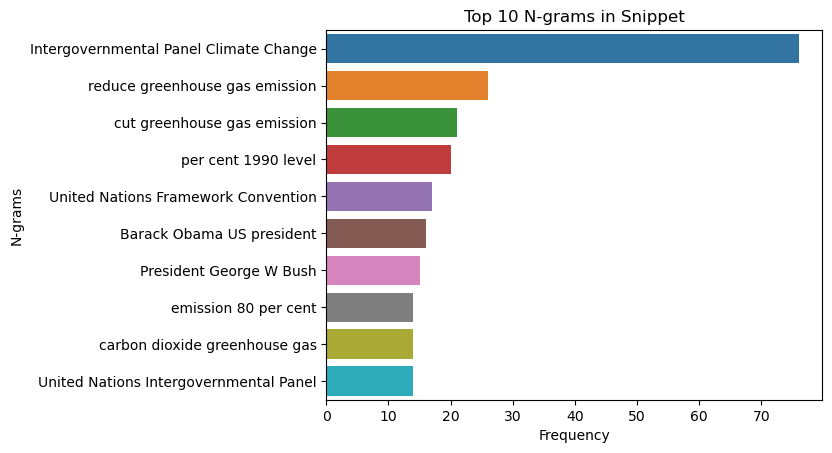

In [16]:
# Remove stopwords
stop_words = set(stopwords.words('english'))
df_merged_data['Snippet'] = df_merged_data['Snippet'].apply(lambda x: [item for item in x if item.lower() not in stop_words])

# Lemmatize words
lemmatizer = WordNetLemmatizer()
df_merged_data['Snippet'] = df_merged_data['Snippet'].apply(lambda x: [lemmatizer.lemmatize(item) for item in x])

# Create n-grams
df_merged_data['Snippet'] = df_merged_data['Snippet'].apply(lambda x: [' '.join(ngram) for ngram in nltk.ngrams(x, 4)])

# Flatten the list of n-grams
all_ngrams = [ngram for snippet in df_merged_data['Snippet'] for ngram in snippet]

# Calculate frequency distribution
ngram_freq = nltk.FreqDist(all_ngrams)

# Get top 10 n-grams
top_ngrams = ngram_freq.most_common(10)

# Plot top 10 n-grams
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(y=[ngram[0] for ngram in top_ngrams], x=[ngram[1] for ngram in top_ngrams])
plt.ylabel('N-grams')
plt.xlabel('Frequency')
plt.title('Top 10 N-grams in Snippet')
plt.show()


In [5]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm.notebook import tqdm
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "SamLowe/roberta-base-go_emotions"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)

model.eval()

def classify_emotion(n_gram):
    inputs = tokenizer(n_gram, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    predicted_class_idx = torch.argmax(outputs.logits, dim=-1).item()
    predicted_class_label = model.config.id2label[predicted_class_idx]
    return predicted_class_label

sentiments = []

for ngram, count in tqdm(top_ngrams, desc="Classifying"):
    sentiment = classify_emotion(ngram)  # Pass only the n-gram text
    sentiments.append(sentiment)


# Create a DataFrame to store the results.
df_ngrams = pd.DataFrame({
    'N-gram': [ngram for ngram, count in top_ngrams],
    'Count': [count for ngram, count in top_ngrams],
    'Sentiment': sentiments
})

# Display the DataFrame or any other operation you need.
print(df_ngrams)

Classifying:   0%|          | 0/10 [00:00<?, ?it/s]

                                   N-gram  Count Sentiment
0    everywhere going get touched climate    544   neutral
1        going get touched climate change    544   neutral
2  melting pot impacted specie everywhere    357   neutral
3    pot impacted specie everywhere going    357   neutral
4    impacted specie everywhere going get    357   neutral
5     specie everywhere going get touched    357   neutral
6        cut greenhouse gas emission half    260   neutral
7      greenhouse gas emission half algae    236   neutral
8       gas emission half algae potential    225   neutral
9      emission half algae potential keep    225   neutral


C:\Users\jules\AppData\Local\Temp\ipykernel_14252\571774940.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Snippet'] = df['Snippet'].astype(str)
C:\Users\jules\AppData\Local\Temp\ipykernel_14252\571774940.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Snippet'] = df['Snippet'].str.lower()
C:\Users\jules\AppData\Local\Temp\ipykernel_14252\571774940.py:27: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Snippet'] = df['Snippet'].str.repla

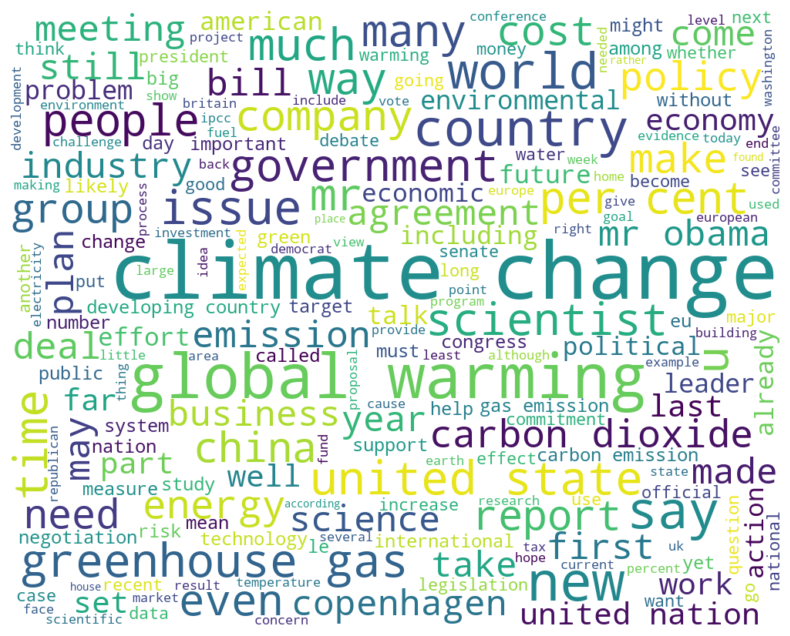

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from wordcloud import WordCloud
from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

df = pd.read_csv('combined_articles-COP15.csv')

def generateWordcloud(df, stopwordList = []):
    # convert 'Content' to 'Snippet'
    df.rename(columns={'Content': 'Snippet'}, inplace=True)

    # Remove rows with NaN in 'Snippet' column
    df = df.dropna(subset=['Snippet'])

    # Convert 'Snippet' column to strings in case there are any non-string types (wordnet breaks otherwise)
    df['Snippet'] = df['Snippet'].astype(str)

    # Lowercase all words
    df['Snippet'] = df['Snippet'].str.lower()

    # Remove punctuation
    df['Snippet'] = df['Snippet'].str.replace('[{}]'.format(string.punctuation), '')

    # Remove stopwords
    stop_words = set(stopwords.words('english'))

    # Add excluded words to stopwords
    stop_words.update(['said', 'would', 'also', 'could', 'year', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten'])
    # Add custom stopwords
    stop_words.update(stopwordList)

    df['Snippet'] = df['Snippet'].apply(lambda x: ' '.join([item for item in x.split() if item.lower() not in stop_words]))

    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    df['Snippet'] = df['Snippet'].apply(lambda x: ' '.join([lemmatizer.lemmatize(item) for item in x.split()]))

    # create wordcloud
    wordcloudNews = WordCloud(width=1000, height=800, background_color="white", colormap='viridis').generate(' '.join(df['Snippet'].astype(str)))

    plt.figure(figsize=(20, 8))
    plt.imshow(wordcloudNews, interpolation="bilinear")
    plt.axis("off")
    plt.show()

generateWordcloud(df)
